In [1]:
%matplotlib inline

import csv
import sys
import requests
import skimage.io
import os
import glob
import pickle
import time

from IPython.display import display, Image, HTML
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import numpy as np
import pandas as pd
import scipy.sparse as sp

sys.path.append('../')
#import helpers

Using TensorFlow backend.


In [2]:
rand_img = np.random.choice(glob.glob('data/StillsDERIVA/15_02_08_jpg/15_02_08_003.mp4.jpg'))

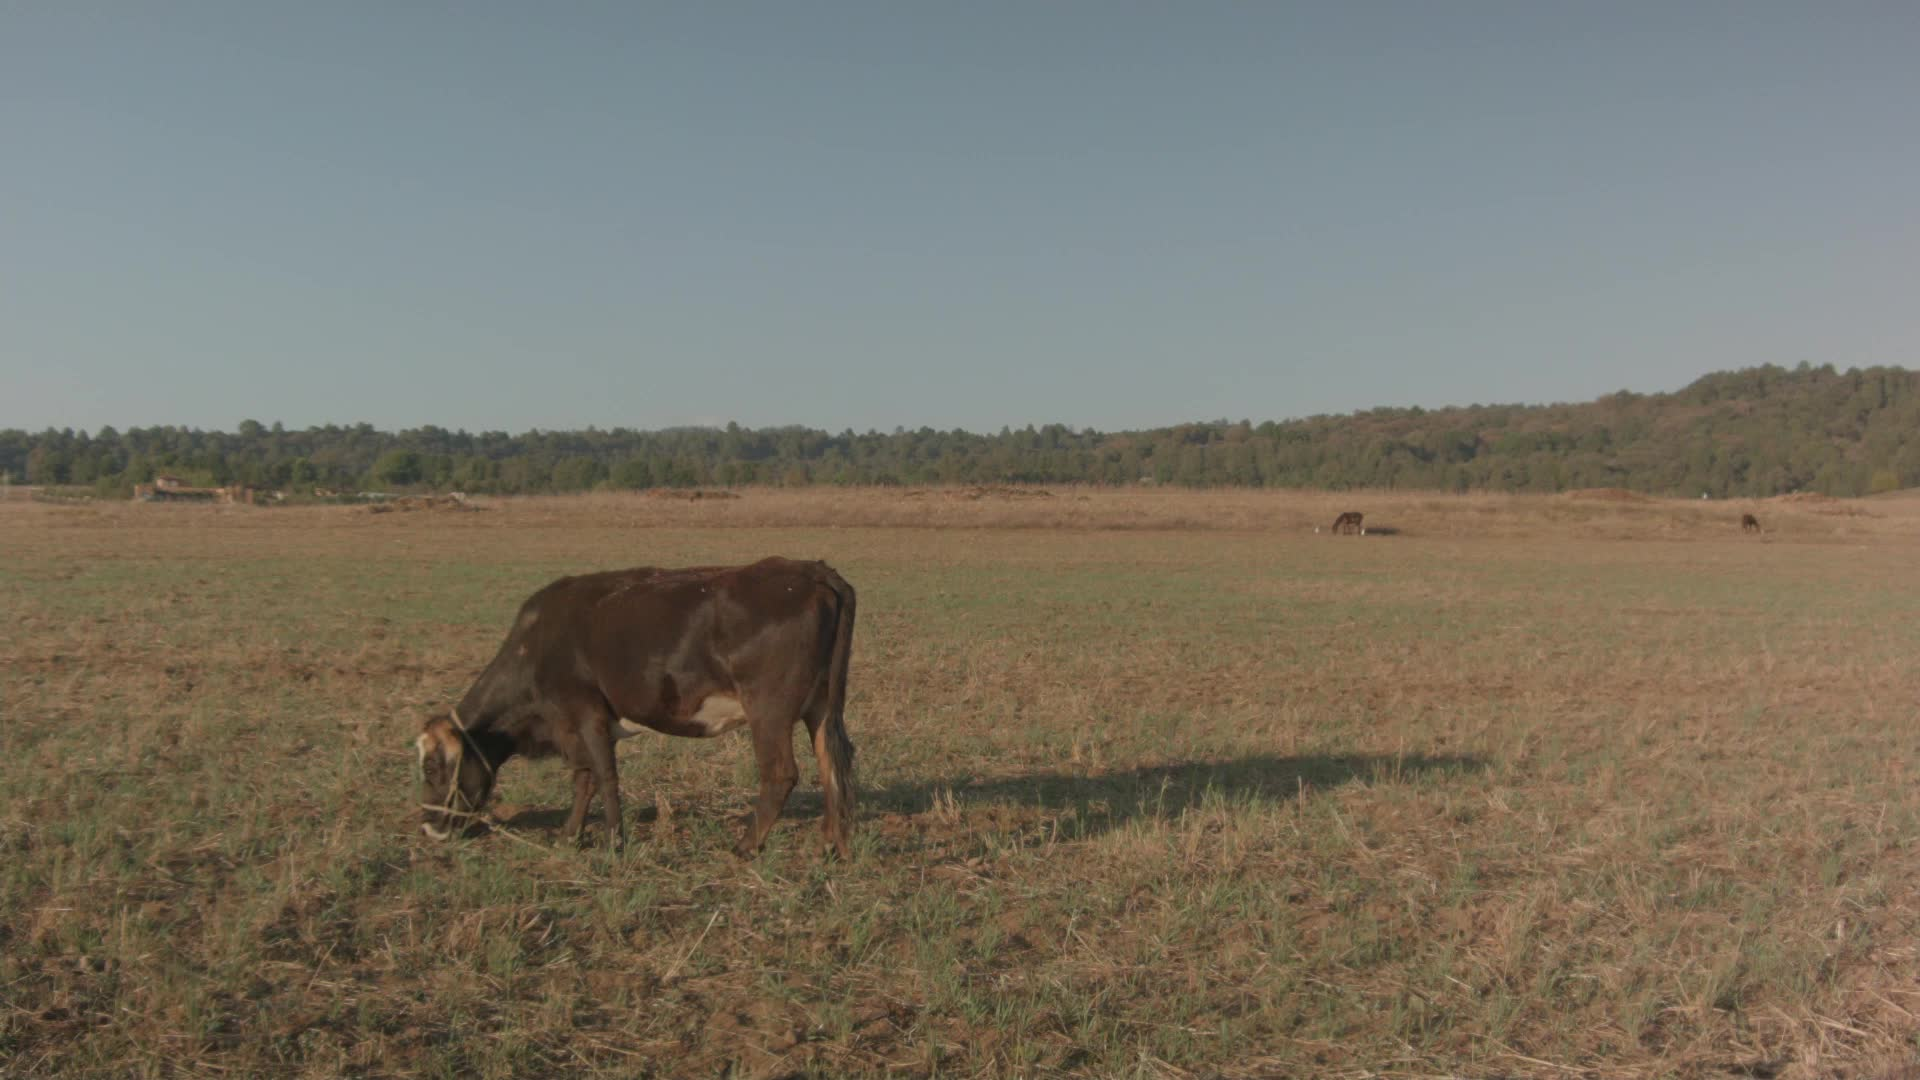

In [3]:
Image(filename=rand_img, width=500, height=500) 

In [4]:
img = skimage.io.imread(rand_img)
img.shape

(1080, 1920, 3)

In [5]:
img = kimage.load_img(rand_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


In [6]:
# image_top=False removes final connected layers
model = VGG16(weights='imagenet', include_top=False)

In [7]:
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

(1, 7, 7, 512)
(25088,)


In [8]:
%%timeit -n5
pred = model.predict(x)

904 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [9]:
fnames = glob.glob('data/StillsDERIVA/*/*.jpg')

In [10]:
idx_to_mid = {}
batch_size = len(fnames)
min_idx = 0
max_idx = min_idx + batch_size
total_max = len(fnames)
n_dims = pred.ravel().shape[0]
px = 224

# Initialize predictions matrix
preds = sp.lil_matrix((len(fnames), n_dims))

In [11]:
fnames[0].split('/')[-1]

'15_02_08_001.mp4.jpg'

In [12]:
while min_idx < total_max - 1:
    t0 = time.time()
    
    X = np.zeros(((max_idx - min_idx), px, px, 3))
    
    # For each file in batch, 
    # load as row into X
    for i in range(min_idx, max_idx):
        fname = fnames[i]
        mid = fnames[0].split('/')[-1]
        idx_to_mid[i] = mid
        img = kimage.load_img(fname, target_size=(px, px))
        img_array = kimage.img_to_array(img)
        X[i - min_idx, :, :, :] = img_array
        if i % 200 == 0 and i != 0:
            t1 = time.time()
            print('{}: {}'.format(i, (t1 - t0) / i))
            t0 = time.time()
    max_idx = i
    t1 = time.time()
    print('{}: {}'.format(i, (t1 - t0) / i))
    
    print('Preprocess input')
    t0 = time.time()
    X = preprocess_input(X)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    print('Predicting')
    t0 = time.time()
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    
    # Place predictions inside full preds matrix.
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    min_idx = max_idx
    max_idx = np.min((max_idx + batch_size, total_max))

200: 0.07006868481636047
400: 0.033374587893486025
539: 0.017185196584584762
Preprocess input
0.6718251705169678
Predicting
568.6262600421906


In [13]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [14]:
preds = preds.tocsr()
sim = cosine_similarity(preds)

In [27]:
def get_thumbnails(sim, idx, idx_to_mid, N=10):
    row = sim[idx, :]
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        yield(x)


def display_similars(sim, idx, idx_to_mid, N=10):
    
    for i in get_thumbnails(sim, idx, idx_to_mid, N + 1):
        if i == idx:
            print('Input Image: ')
            display(Image(filename=fnames[i],  width=300, height=300))
            print('Similar Images: ')
        else:
            display(Image(filename=fnames[i],  width=300, height=300))
    

Input Image: 


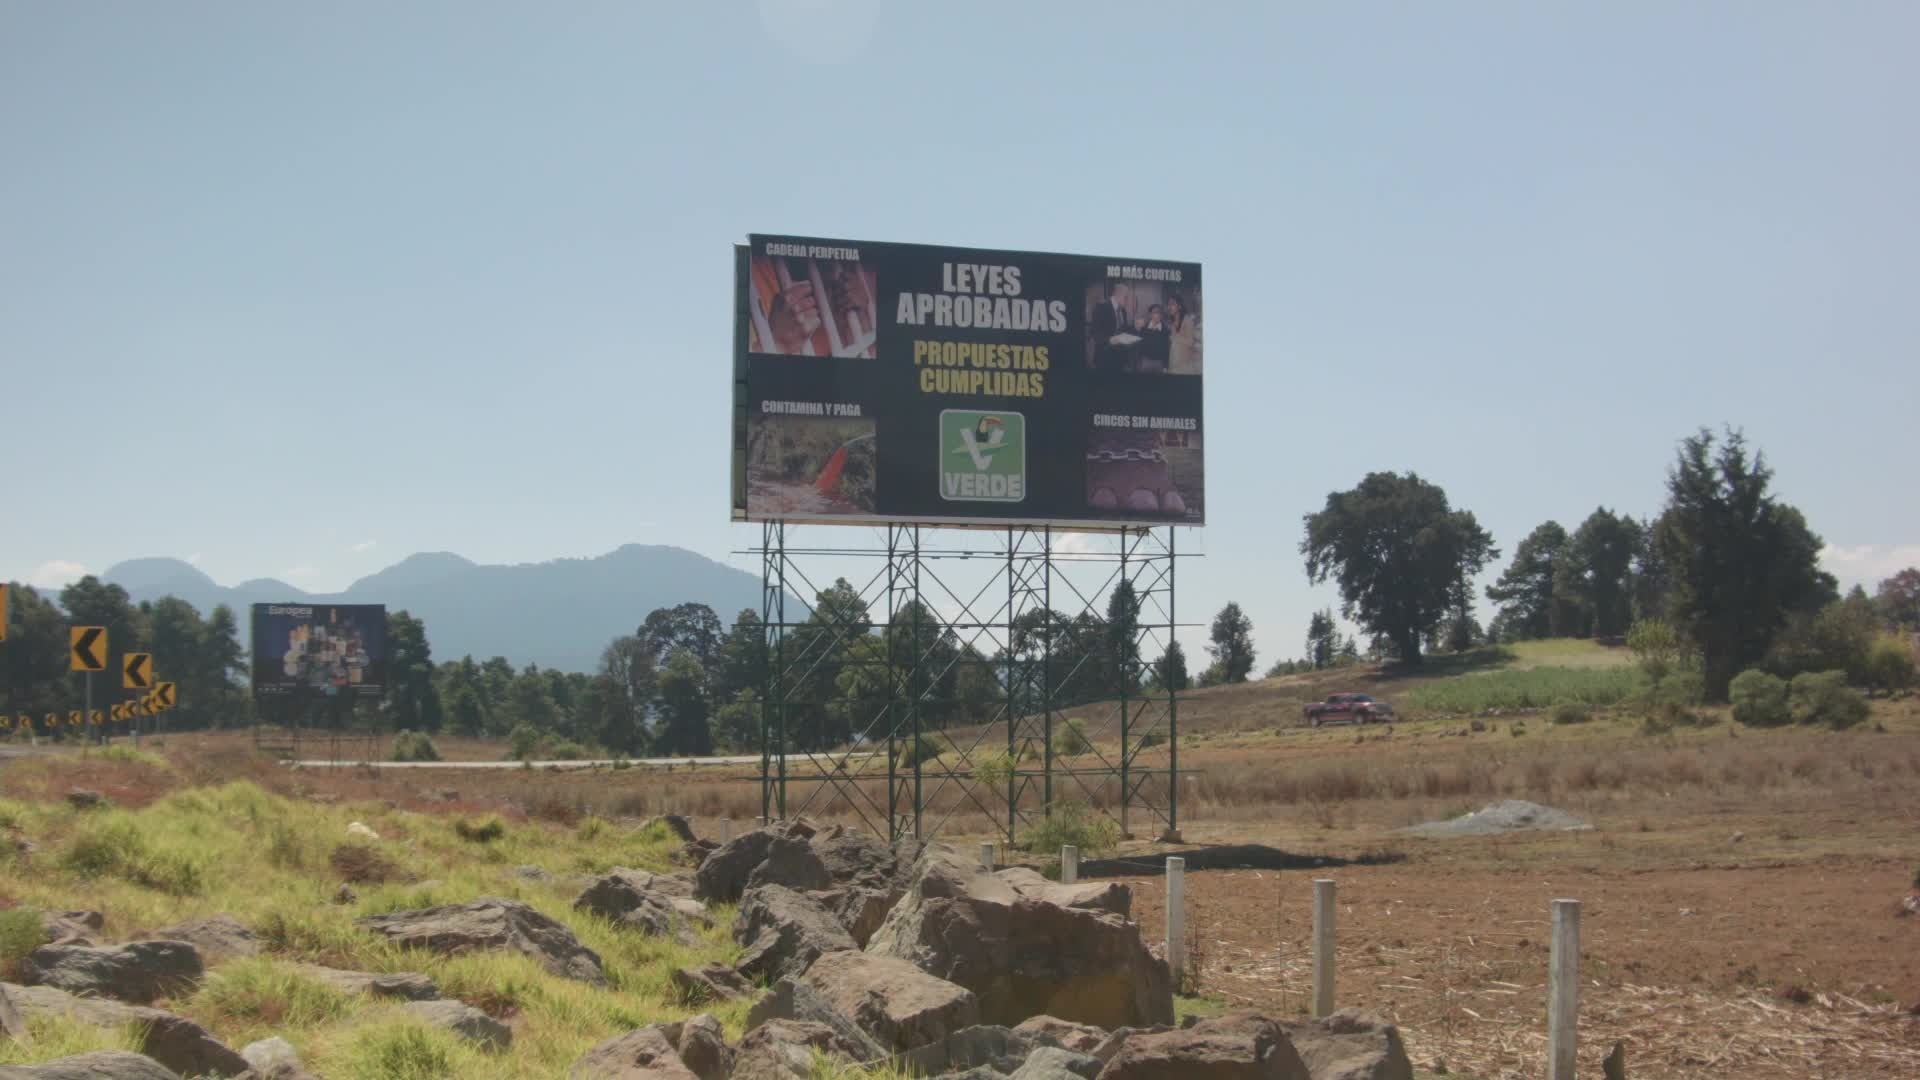

Similar Images: 


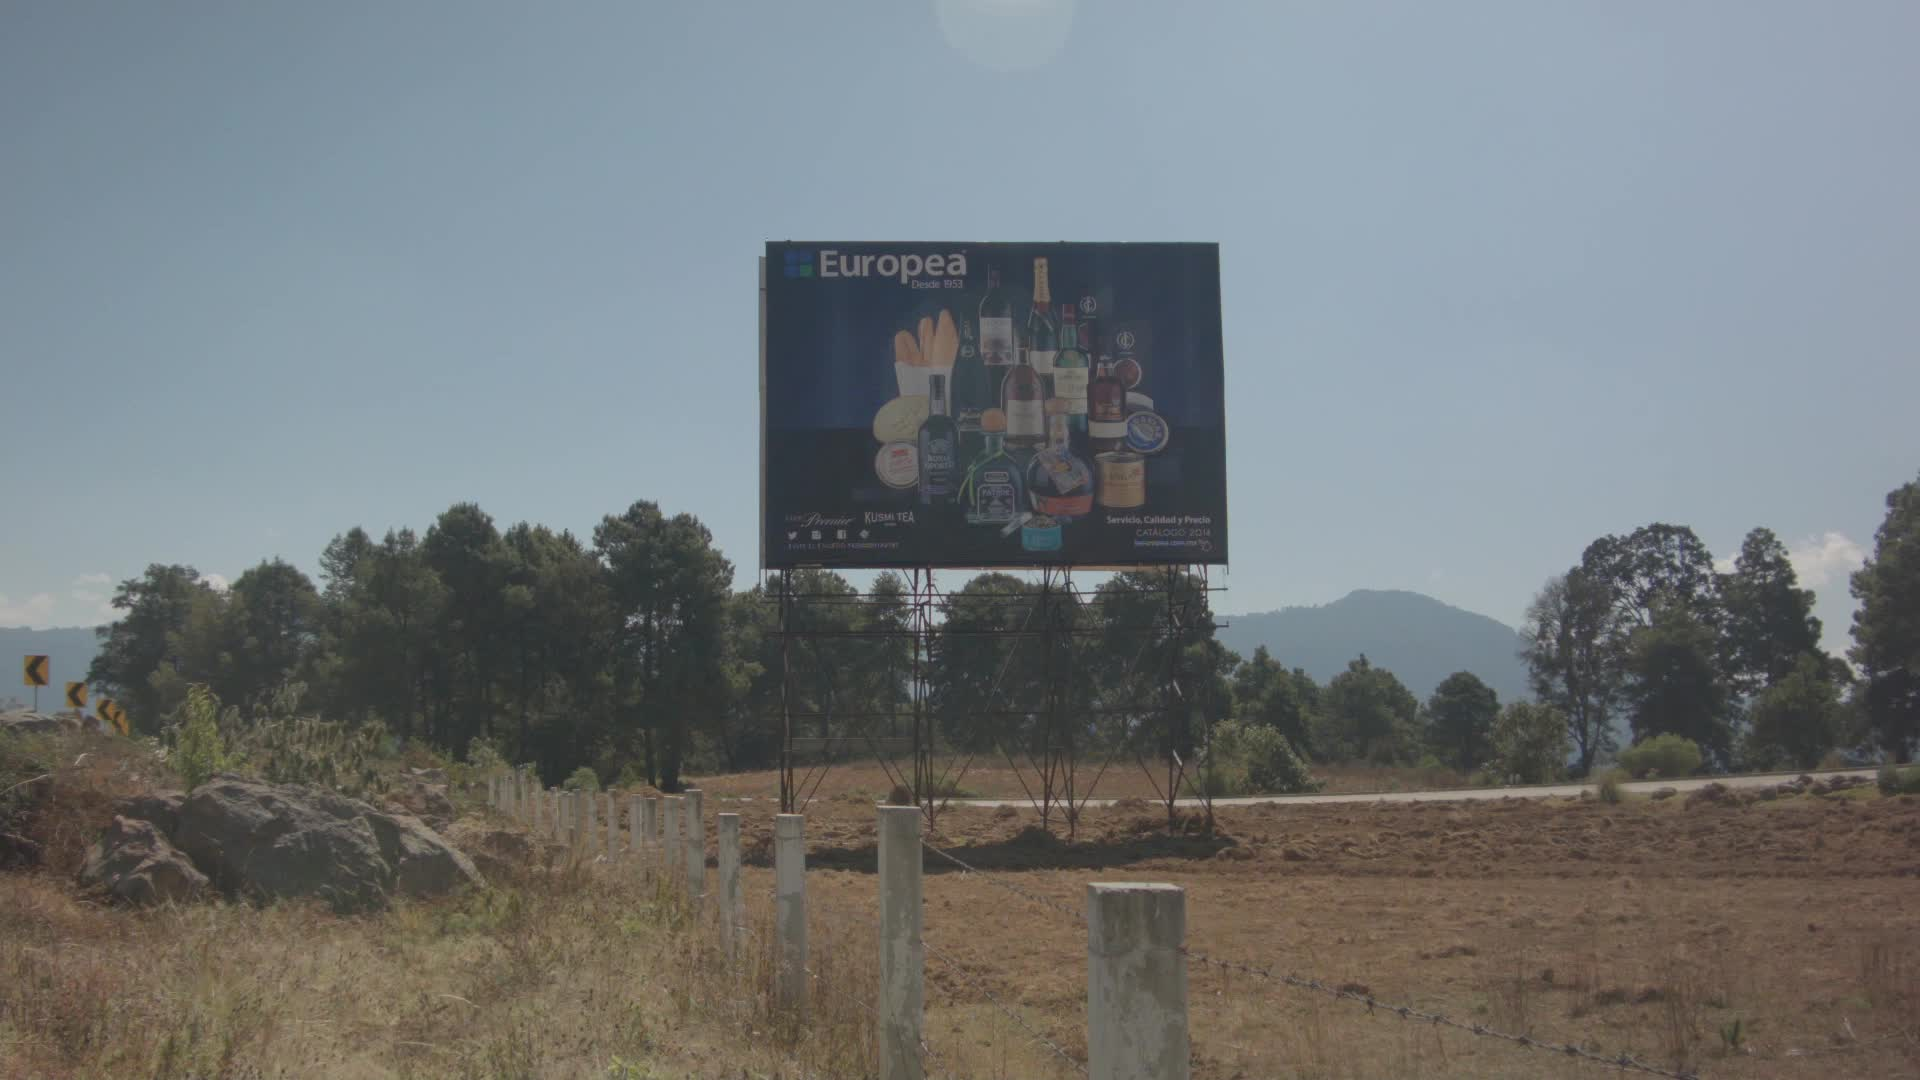

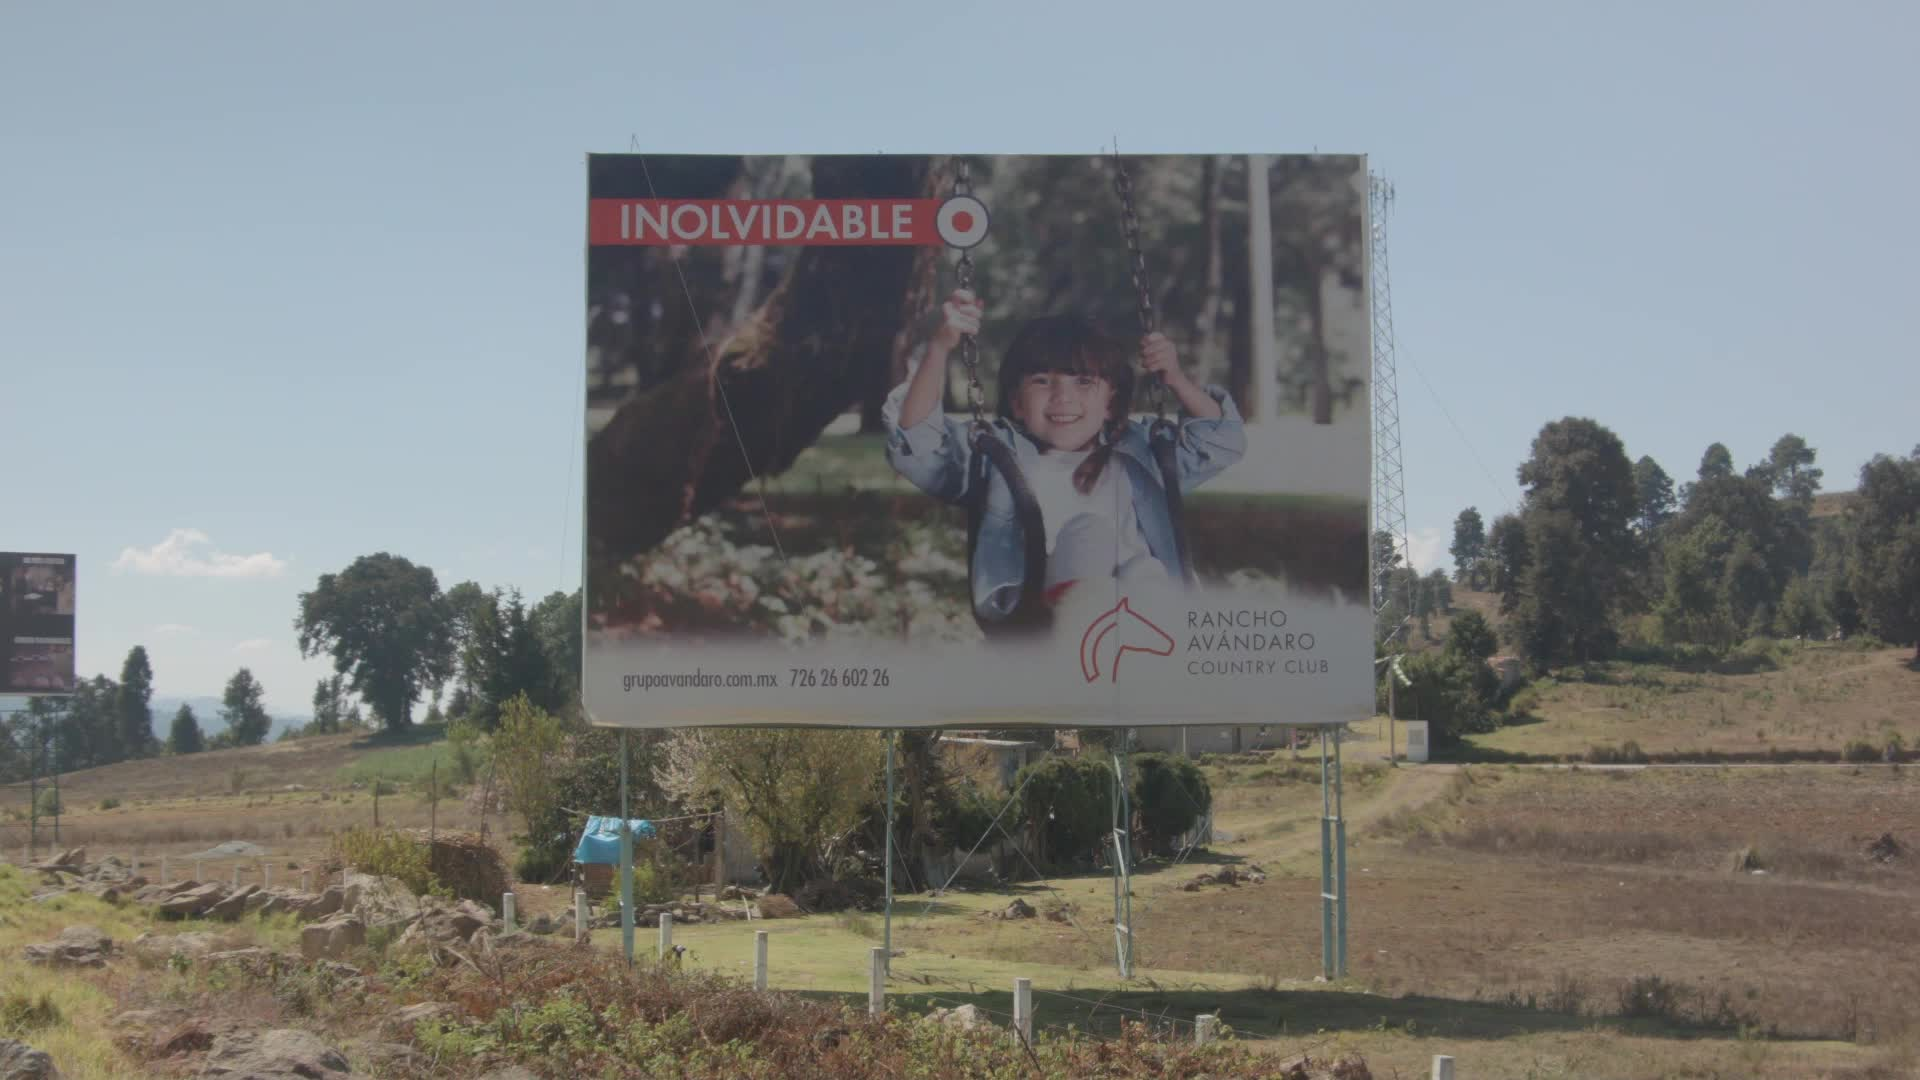

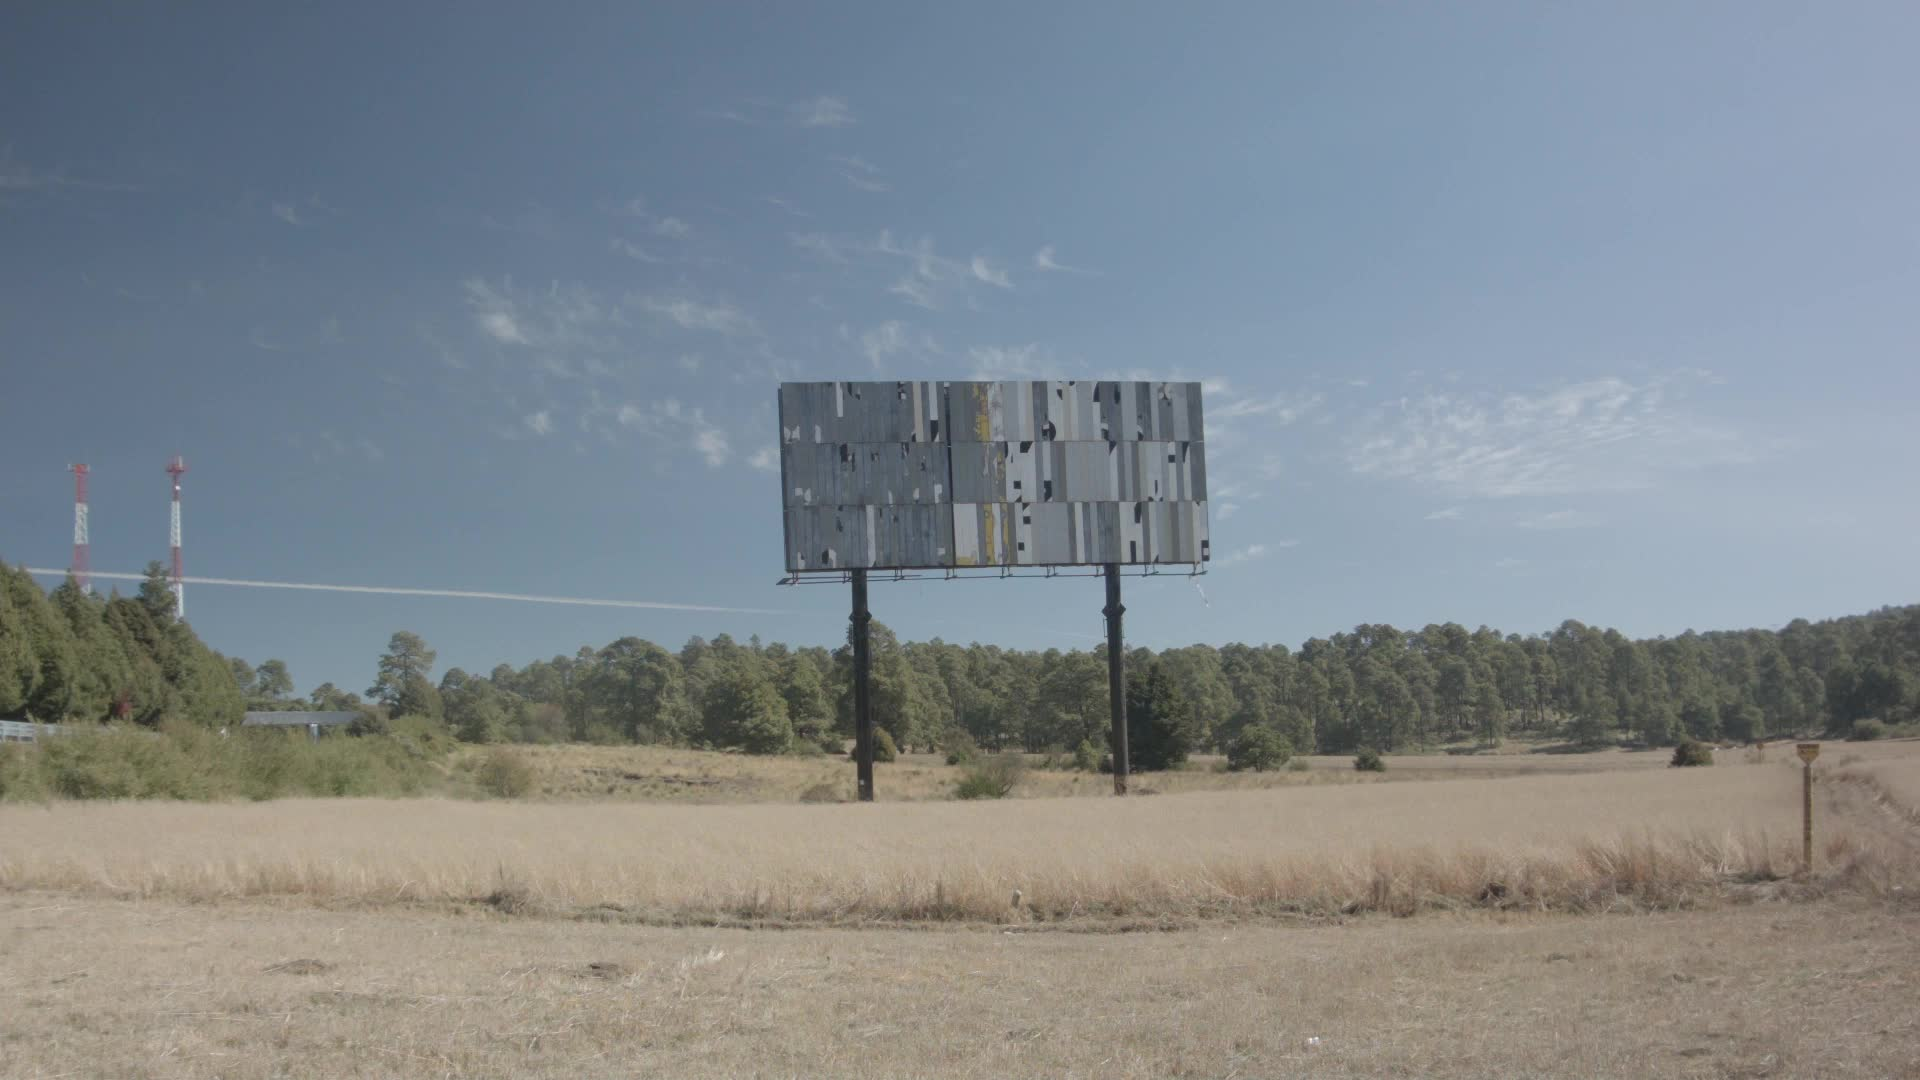

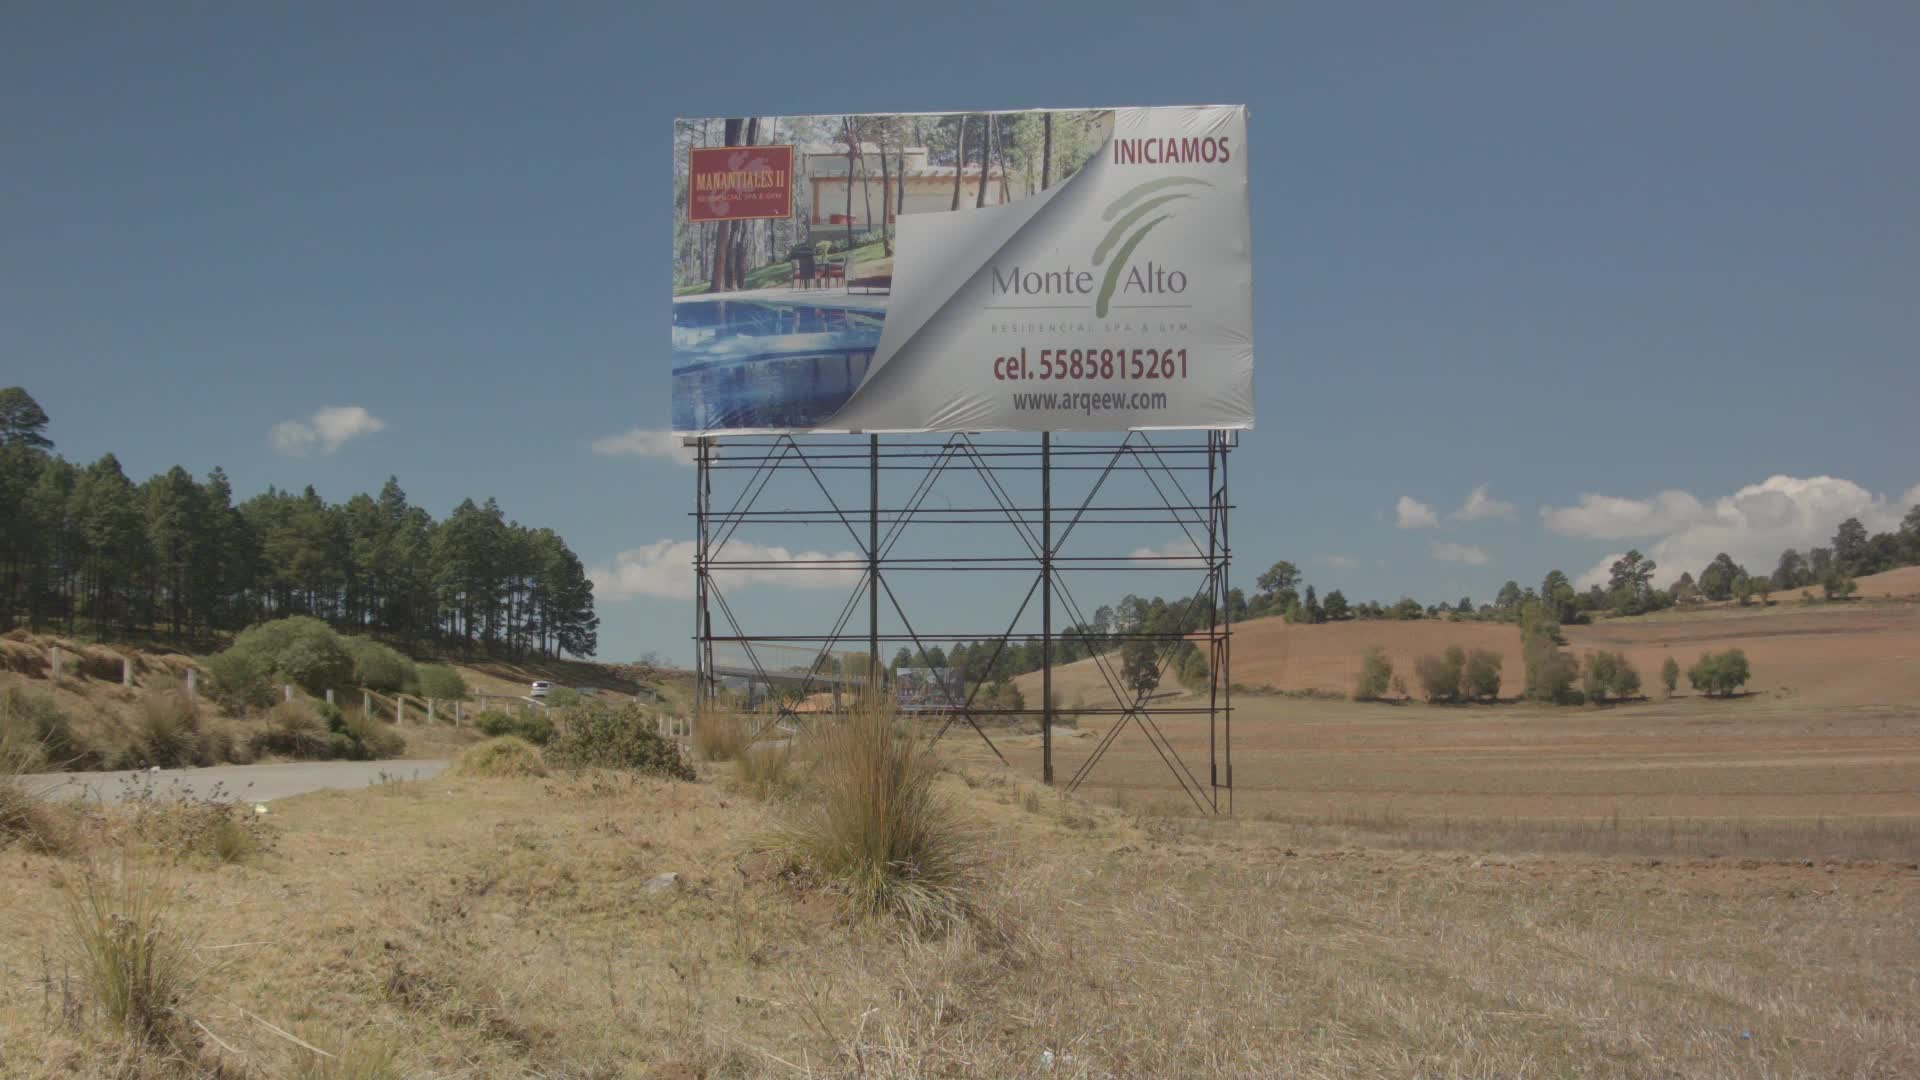

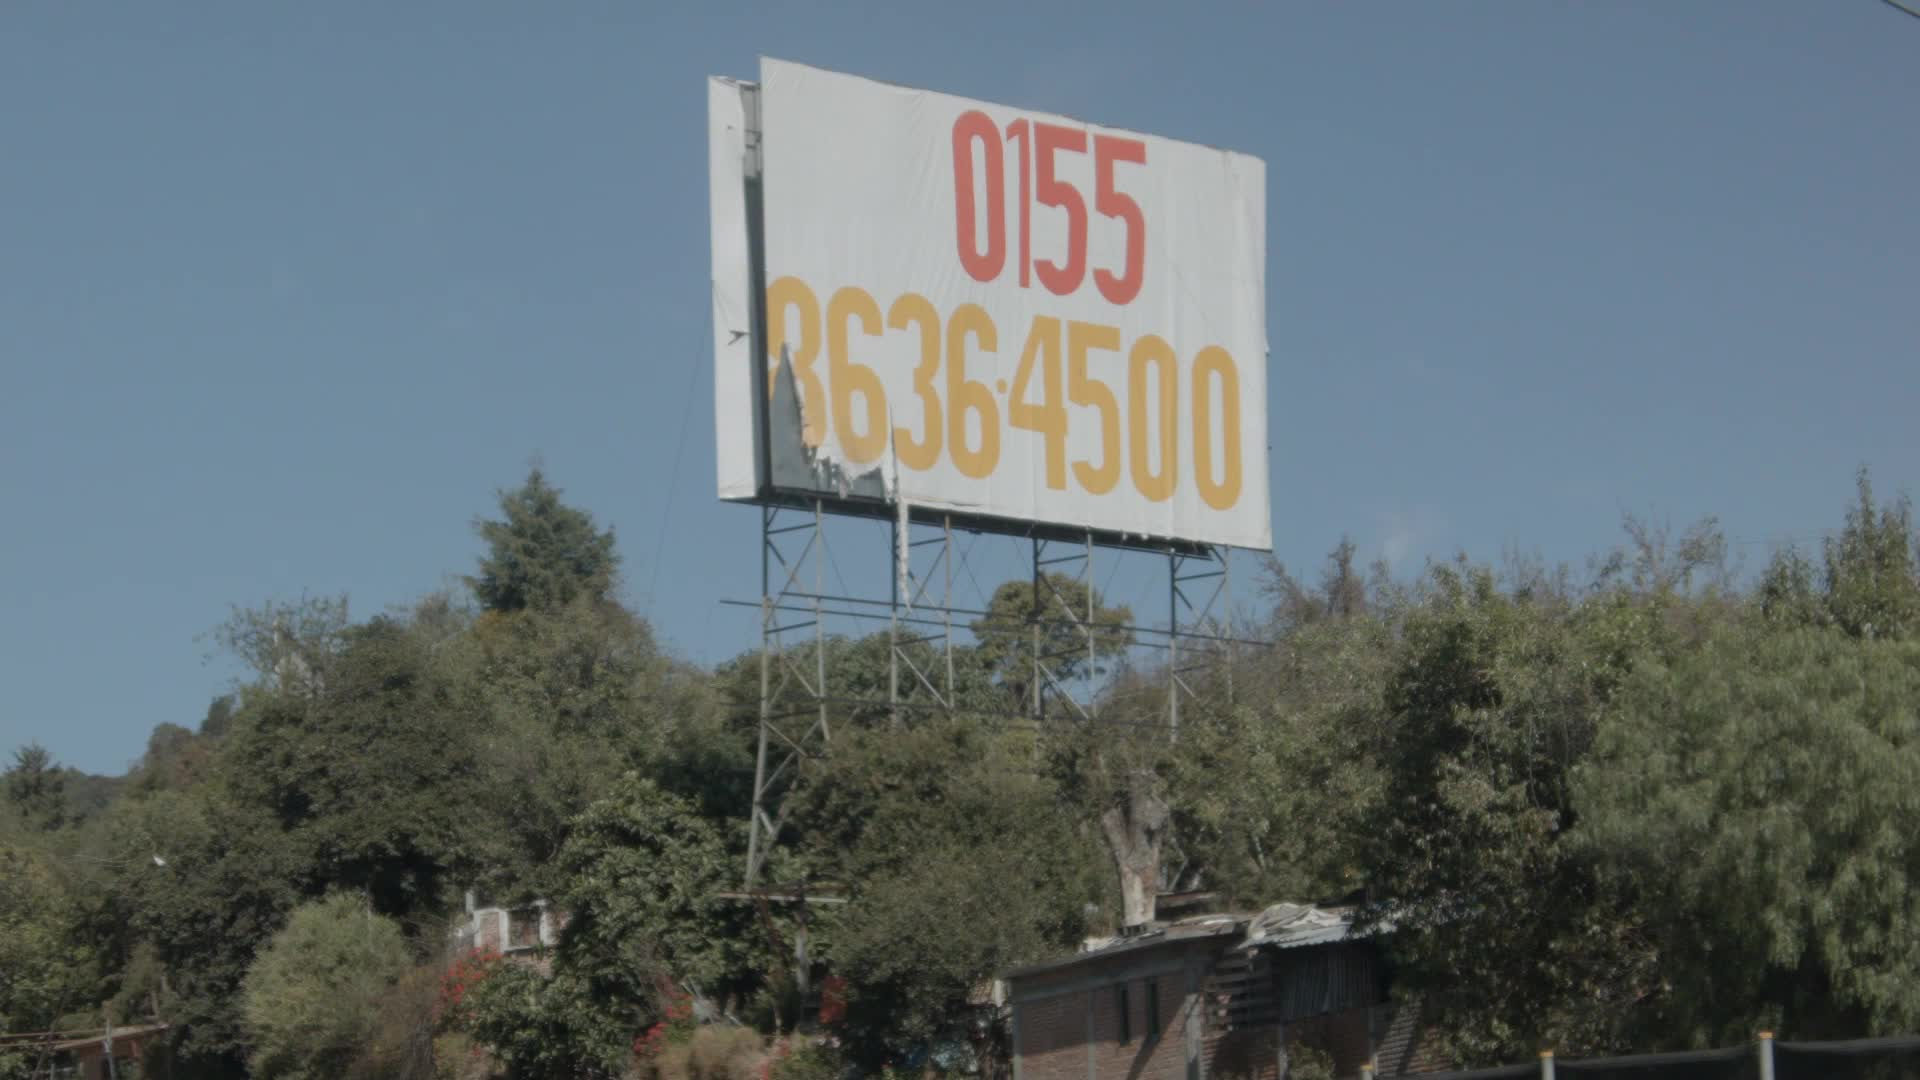

In [28]:
display_similars(sim, 9, idx_to_mid, N=5)